In [102]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from adjustText import adjust_text
import multiprocessing

In [103]:
cores = multiprocessing.cpu_count()

In [104]:
df_data = pd.read_csv('Data/cleaned_hotel_reviews.csv')

In [105]:
encoding_label = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4
}

In [106]:
df_data['Rating'] = df_data['Rating'].map(encoding_label)
df_data = pd.get_dummies(df_data, columns=['Rating'])
df_data

,Review,label,clean_punc,lemmatized_review,number_review,ner_review,Rating_0,Rating_1,Rating_2,Rating_3,Rating_4
0,nice hotel expensive parking got good deal sta...,positive,nice hotel expensive parking got good deal sta...,nice hotel expensive parking get good deal sta...,nice hotel expensive parking get good deal sta...,nice hotel expensive parking get good deal sta...,False,False,False,True,False
1,ok nothing special charge diamond member hilto...,negative,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member PERSO...,False,True,False,False,False
2,nice rooms not 4* experience hotel monaco seat...,neutral,nice rooms not 4 experience hotel monaco seat...,nice room not 4 experience hotel monaco seat...,nice room not experience hotel monaco seattle ...,nice room not experience hotel monaco seattle ...,False,False,True,False,False
3,"unique, great stay, wonderful time hotel monac...",positive,unique great stay wonderful time hotel monac...,unique great stay wonderful time hotel mon...,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time ORG ORG locat...,False,False,False,False,True
4,"great stay great stay, went seahawk game aweso...",positive,great stay great stay went seahawk game aweso...,great stay great stay go seahawk game awesom...,great stay great stay go seahawk game awesome ...,great stay great stay go ORG game awesome down...,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",positive,best kept secret 3rd time staying charm not 5...,well keep secret 3rd time stay charm not 5 s...,well keep secret time stay charm not star can ...,well keep secret time stay charm not star can ...,False,False,False,False,True
20487,great location price view hotel great quick pl...,positive,great location price view hotel great quick pl...,great location price view hotel great quick pl...,great location price view hotel great quick pl...,great location price view hotel great quick pl...,False,False,False,True,False
20488,"ok just looks nice modern outside, desk staff ...",negative,ok just looks nice modern outside desk staff ...,ok just look nice modern outside desk staff ...,ok just look nice modern outside desk staff no...,ok just look nice modern outside desk staff no...,False,True,False,False,False
20489,hotel theft ruined vacation hotel opened sept ...,negative,hotel theft ruined vacation hotel opened sept ...,hotel theft ruin vacation hotel open sept 17 2...,hotel theft ruin vacation hotel open sept gues...,hotel theft ruin vacation hotel open DATE DATE...,True,False,False,False,False


In [107]:
x_train, x_test, y_train, y_test = train_test_split(df_data['lemmatized_review'], df_data.iloc[:,6:], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((16392,), (4099,), (16392, 5), (4099, 5))

In [108]:
sentences = df_data['ner_review'].str.split().tolist()

model_wv = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=cores-1)

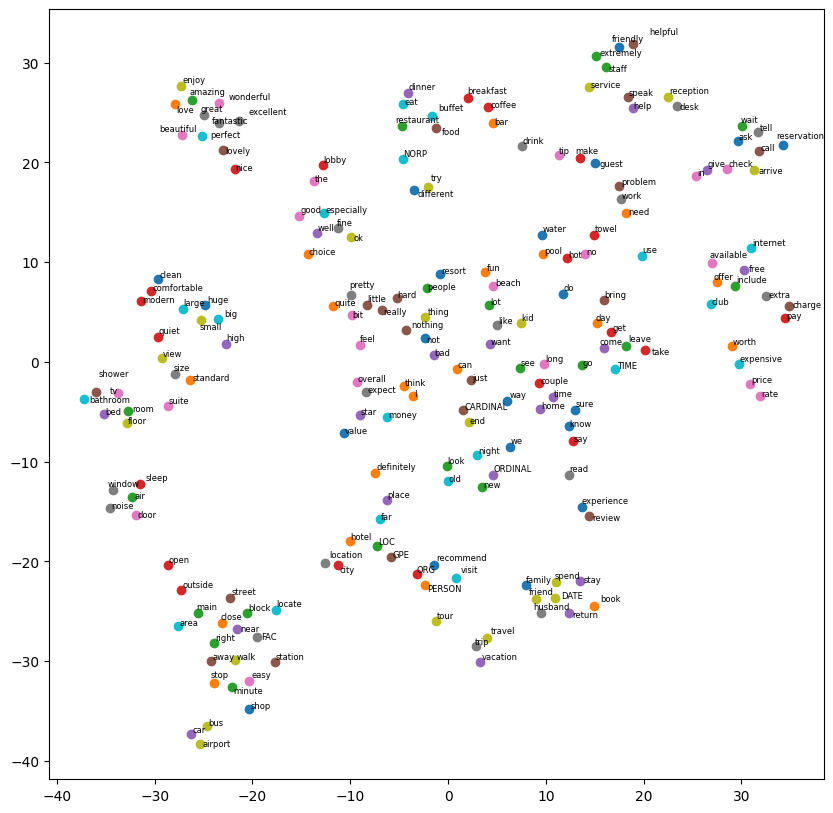

In [122]:
words = list(model_wv.wv.key_to_index)[:200]
embeddings = model_wv.wv[words]

pca = PCA(n_components=8, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=10).fit_transform(pca)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, word in enumerate(words):
    x, y = embeddings_2d[i]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=6)

adjust_text(ax.texts)
plt.show()

In [110]:
MAXLEN = 32
MAX_EXAMPLES = len(model_wv.wv.key_to_index)
EMBEDDING_DIM = model_wv.wv.vector_size
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = '<OOV>'
NUM_LABELS = 5

embedding_matrix = np.zeros((MAX_EXAMPLES, EMBEDDING_DIM))
for word, i in model_wv.wv.key_to_index.items():
    embedding_matrix[i] = model_wv.wv[word]

In [111]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [112]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN,weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 32, 100)           3538400   
                                                                 
 flatten_11 (Flatten)        (None, 3200)              0         
                                                                 
 dense_22 (Dense)            (None, 64)                204864    
                                                                 
 dense_23 (Dense)            (None, 5)                 325       
                                                                 
Total params: 3,743,589
Trainable params: 205,189
Non-trainable params: 3,538,400
_________________________________________________________________


In [113]:
history = model.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test))

Epoch 1/10
513/513 [==============================] - 4s 6ms/step - loss: 1.3741 - accuracy: 0.4223 - true_positives_6: 3336.0000 - true_negatives_6: 62277.0000 - false_positives_6: 3291.0000 - false_negatives_6: 13056.0000 - val_loss: 1.2700 - val_accuracy: 0.4584 - val_true_positives_6: 975.0000 - val_true_negatives_6: 15612.0000 - val_false_positives_6: 784.0000 - val_false_negatives_6: 3124.0000
Epoch 2/10
513/513 [==============================] - 2s 5ms/step - loss: 1.1601 - accuracy: 0.5123 - true_positives_6: 4911.0000 - true_negatives_6: 62834.0000 - false_positives_6: 2734.0000 - false_negatives_6: 11481.0000 - val_loss: 1.2487 - val_accuracy: 0.4647 - val_true_positives_6: 1074.0000 - val_true_negatives_6: 15582.0000 - val_false_positives_6: 814.0000 - val_false_negatives_6: 3025.0000
Epoch 3/10
513/513 [==============================] - 3s 5ms/step - loss: 1.0333 - accuracy: 0.5758 - true_positives_6: 6170.0000 - true_negatives_6: 62890.0000 - false_positives_6: 2678.0000 -

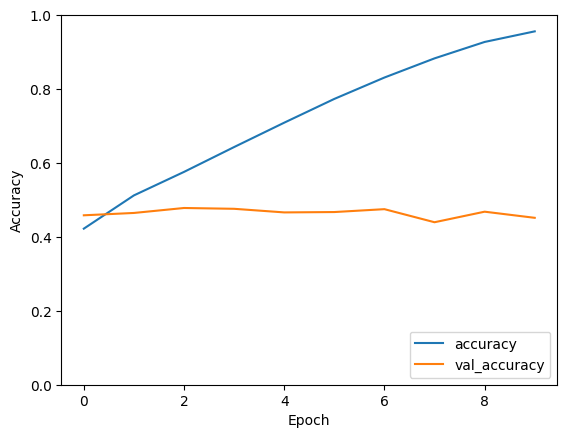

In [114]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()